In [5]:
import os
import random
import torch
import torchvision.transforms as standard_transforms
import scipy.io as sio
import matplotlib
import pandas as pd
import misc.transforms as own_transforms
import warnings


from torch.autograd import Variable
from torch.utils.data import DataLoader
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from tqdm import trange, tqdm
from misc.utils import *
from models.CC import CrowdCounter
from config import cfg
import CCAugmentation as cca
from datasets.SHHB.setting import cfg_data
from load_data import CustomDataset

torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True
warnings.filterwarnings('ignore')

mean_std = ([0.452016860247, 0.447249650955, 0.431981861591],[0.23242045939, 0.224925786257, 0.221840232611])

img_transform = standard_transforms.Compose([
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(*mean_std)
    ])
restore = standard_transforms.Compose([
        own_transforms.DeNormalize(*mean_std),
        standard_transforms.ToPILImage()
    ])
pil_to_tensor = standard_transforms.ToTensor()

In [15]:
# model_path = './exp/11-29_09-50_SHHB_CSRNet_1e-05_[noAug]/all_ep_112_mae_10.30_mse_18.06.pth'
# model_path = './exp/11-29_13-39_SHHB_CSRNet_1e-05_[noAug]/all_ep_121_mae_12.12_mse_20.69.pth'
# model_path = './exp/11-29_17-57_SHHB_CSRNet_1e-05_[noAug]/all_ep_097_mae_11.18_mse_17.59.pth'

# model_path = './exp/11-26_08-28_SHHB_CSRNet_1e-05_[0]/all_ep_189_mae_11.13_mse_17.04.pth'
# model_path = './exp/11-26_11-30_SHHB_CSRNet_1e-05_[0]/all_ep_168_mae_12.35_mse_17.60.pth'
# model_path = './exp/11-26_14-31_SHHB_CSRNet_1e-05_[0]/all_ep_185_mae_11.21_mse_16.96.pth'

# model_path = './exp/11-29_06-54_SHHB_CSRNet_1e-05_[1]/all_ep_241_mae_0.38_mse_0.60.pth'



net = CrowdCounter(cfg.GPU_ID,cfg.NET)
net.load_state_dict(torch.load(model_path))
net.cuda()
net.eval()              


val_pipeline = cca.Pipeline(
        cca.examples.loading.SHHLoader("/dataset/ShanghaiTech", "test", "B"), []
    ).execute_generate()
val_loader = DataLoader(CustomDataset(val_pipeline), batch_size=cfg_data.VAL_BATCH_SIZE, num_workers=1, drop_last=False)

val_img = list(val_loader)

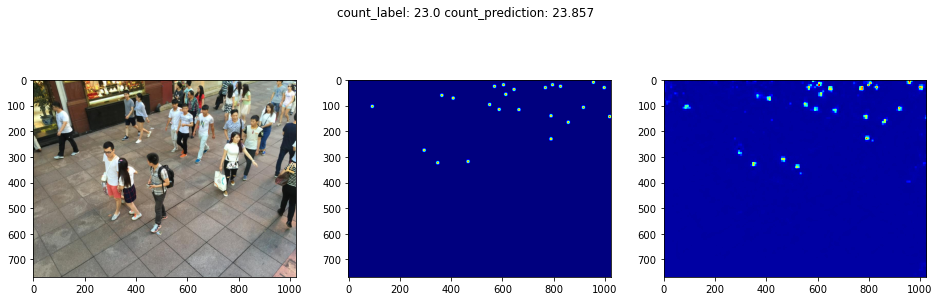

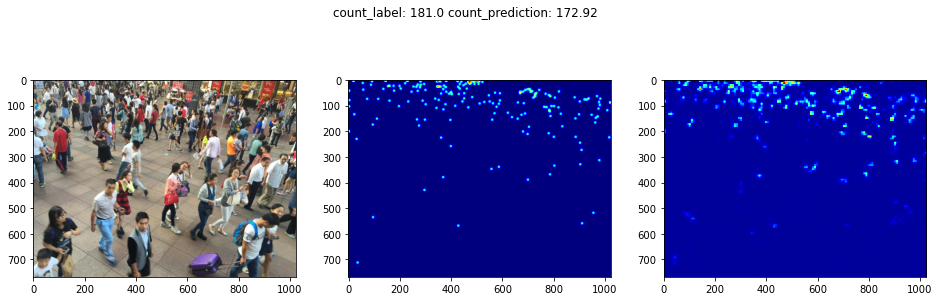

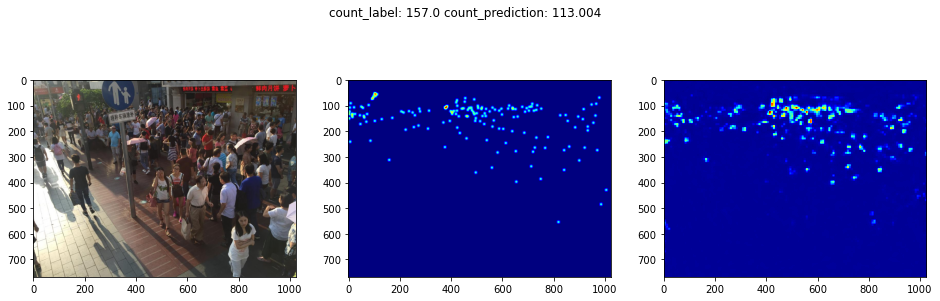

In [16]:
start = 0
N = 3

for vi, data in enumerate(val_img[start:start+N], 0):
    img, gt_map = data

    with torch.no_grad():
        img = Variable(img).cuda()
        pred_map = net.test_forward(img)
        pred_map = pred_map.data.cpu().numpy()
        
    new_img = img.data.cpu().numpy()
    new_img = np.moveaxis(new_img, 1, 2)
    new_img = np.moveaxis(new_img, 2, 3)
    new_img = np.squeeze(new_img)[:,:,::-1]
    
    pred_cnt = np.sum(pred_map[0])/100.0
    gt_count = np.sum(gt_map.data.cpu().numpy())/100.0
    
    fg, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
    plt.suptitle(' '.join([
            'count_label:', str(round(gt_count, 3)),
            'count_prediction:', str(round(pred_cnt, 3))
        ]))
    ax0.imshow(np.uint8(new_img))
    ax1.imshow(np.squeeze(gt_map), cmap='jet')
    ax2.imshow(np.squeeze(pred_map), cmap='jet')
    plt.show()

In [17]:
mae = np.empty(len(val_img))
mse = np.empty(len(val_img))
for vi, data in enumerate(tqdm(val_img), 0):
    img, gt_map = data

    with torch.no_grad():
        img = Variable(img).cuda()
        pred_map = net.test_forward(img)
        pred_map = pred_map.data.cpu().numpy()
    
    pred_cnt = np.sum(pred_map[0])/100.0
    gt_count = np.sum(gt_map.data.cpu().numpy())/100.0
    mae[vi] = np.abs(gt_count-pred_cnt)
    mse[vi] = (gt_count-pred_cnt)**2
    
print('MAE:', round(mae.mean(),2))
print('MSE:', round(np.sqrt(mse.mean()),2))

100%|██████████| 316/316 [00:32<00:00,  9.63it/s]

MAE: 12.53
MSE: 19.79


## 